## Plot all FT's

In [2]:
from pathlib import Path
from skimage import io
import numpy as np
import napari
from os.path import exists
from brainlit.utils.session import NeuroglancerSession
from cloudvolume.exceptions import SkeletonDecodeError
from napari_animation import AnimationWidget
from cloudvolume import CloudVolume
from brainlit.utils import NeuronTrace
from pynufft import NUFFT
from tqdm import tqdm

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib widget


dir = "precomputed://s3://open-neurodata/brainlit/brain1"
dir_segments = "precomputed://s3://open-neurodata/brainlit/brain1_segments"
mip = 0
vol = CloudVolume(dir_segments, mip=mip)

num_goal = 0
num = -1
skel_id = -1

while num < num_goal:
    skel_id += 1
    try:
        skel = vol.skeleton.get(skel_id)
        print(f"Skeleton # {skel_id} exists")
        num += 1
    except SkeletonDecodeError:
        print(f"#{skel_id} invalid")

neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

paths = neuron.get_paths()  # coordinates are in nm

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


#0 invalid
#1 invalid
Skeleton # 2 exists


processing neurons:   0%|          | 0/50 [00:00<?, ?it/s]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.043009959313246846
2.7219112300732173


processing neurons:   2%|▏         | 1/50 [00:09<08:05,  9.91s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06521784588187773
1.8379882427644043


processing neurons:   4%|▍         | 2/50 [00:24<10:19, 12.90s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.07646920732182179
1.4554001213006336


processing neurons:   6%|▌         | 3/50 [00:40<11:07, 14.21s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06854567750436948
2.1554712937732323


processing neurons:   8%|▊         | 4/50 [01:04<13:52, 18.10s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.0413359146882816
3.633676657547946


1 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.09296730941208858
1.0783669966819793


processing neurons:  10%|█         | 5/50 [01:23<13:47, 18.40s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.03563823930702865
3.585322032927892


processing neurons:  14%|█▍        | 7/50 [01:55<11:43, 16.35s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06666086679014308
1.6953786247552183


processing neurons:  16%|█▌        | 8/50 [02:10<11:08, 15.93s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.05089259725634852
2.5241449899329043


1 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.08209805491788731
1.7256168792141544


2 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.09994775097156491
1.5712345985390688


processing neurons:  18%|█▊        | 9/50 [02:35<12:44, 18.65s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.049980689842200596
2.6943376265651495


2 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.12695397465913166
1.2251865998239606


processing neurons:  22%|██▏       | 11/50 [03:06<10:25, 16.03s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06341580089389147
1.8685001817148823


processing neurons:  24%|██▍       | 12/50 [03:09<07:45, 12.25s/it]

1 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.16866004056258507
1.1101096067660392


processing neurons:  30%|███       | 15/50 [03:26<04:52,  8.36s/it]

1 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.18178350151507733
1.6427012043986644


processing neurons:  34%|███▍      | 17/50 [03:34<03:17,  5.99s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06888989842375694
1.9312513329956418


processing neurons:  44%|████▍     | 22/50 [04:07<02:41,  5.78s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06331832500565122
2.4417242075163714


processing neurons:  48%|████▊     | 24/50 [04:26<03:00,  6.93s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.055151935883676916
1.4728936756576543


processing neurons:  56%|█████▌    | 28/50 [05:02<02:54,  7.94s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.05616792381601249
1.0987435897547477


processing neurons:  62%|██████▏   | 31/50 [05:17<01:56,  6.13s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.047701219594545624
2.879215068415965


processing neurons:  64%|██████▍   | 32/50 [05:39<03:14, 10.83s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.0865304428818357
2.0452021876121202


processing neurons:  66%|██████▌   | 33/50 [05:44<02:35,  9.14s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.057187221299860674
2.251092004261514


processing neurons:  68%|██████▊   | 34/50 [06:10<03:46, 14.17s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.04569834609490491
2.3697813388543527


1 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.10075671482317014
1.1295416555208229


processing neurons:  70%|███████   | 35/50 [06:42<04:50, 19.34s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.03222473041058818
5.43692714789713


processing neurons:  72%|███████▏  | 36/50 [06:57<04:14, 18.20s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.03469827921813282
3.6187238105647315


processing neurons:  74%|███████▍  | 37/50 [07:17<04:03, 18.76s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06255907482886906
2.274698137058816


2 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.10418029873251683
1.1234439772963376


9 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.15736951987736408
1.2214292442405066


processing neurons:  76%|███████▌  | 38/50 [07:50<04:35, 22.98s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06178961869487646
2.0932920482548214


processing neurons:  82%|████████▏ | 41/50 [08:11<01:50, 12.28s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.05013560260700472
2.6357930520090864


processing neurons:  86%|████████▌ | 43/50 [08:28<01:08,  9.78s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.040767819277315265
3.4047964179490577


processing neurons:  90%|█████████ | 45/50 [08:40<00:39,  7.87s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.03246882832723698
3.651859013770936


processing neurons:  92%|█████████▏| 46/50 [08:51<00:34,  8.70s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.04339033564508216
2.981899699867945


processing neurons:  98%|█████████▊| 49/50 [09:15<00:07,  7.77s/it]

0 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.06317838877428467
2.081423681021299


2 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.05764536385479131
2.082988627250485


5 path error does not fall below 1 min error: [1.25607397e-15 7.85046229e-17 8.88178420e-16], max freq: 0.07019612685456568
1.5657990172673224


processing neurons: 100%|██████████| 50/50 [09:52<00:00, 11.86s/it]


6138/6176 achieve error below 1


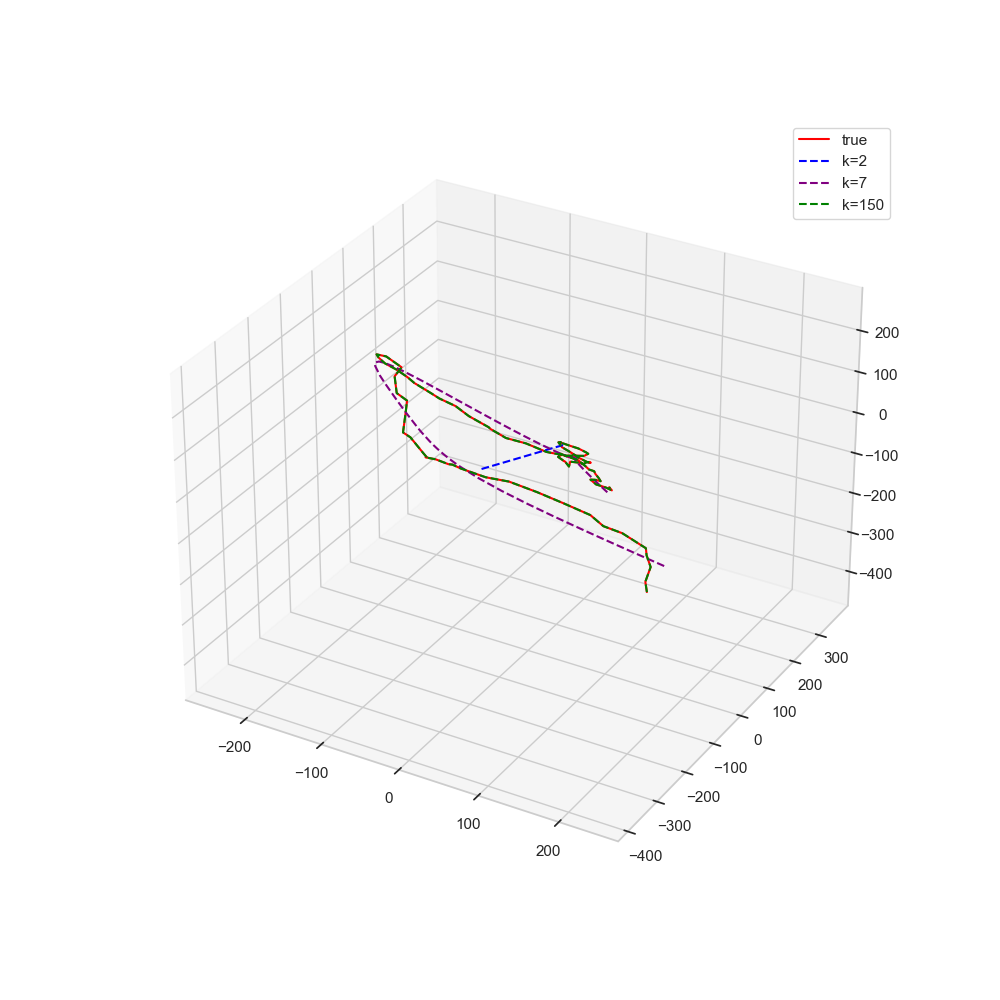

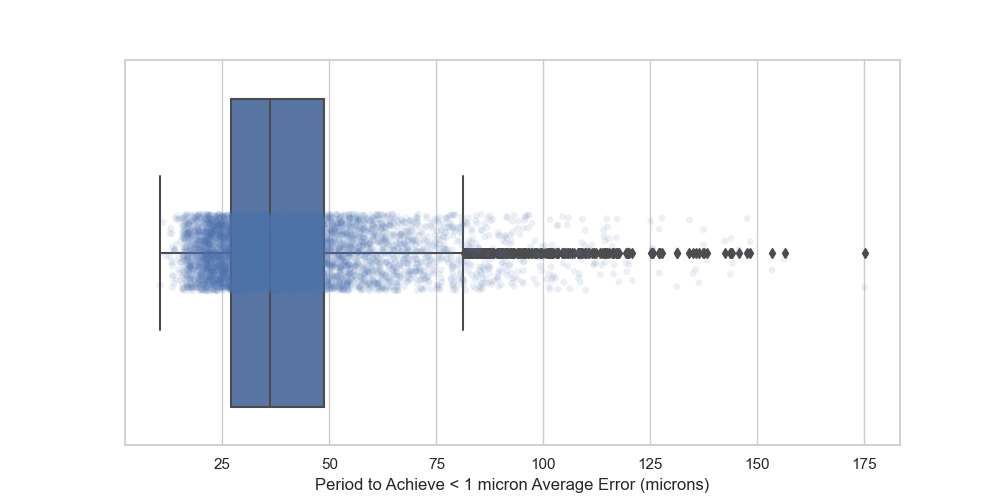

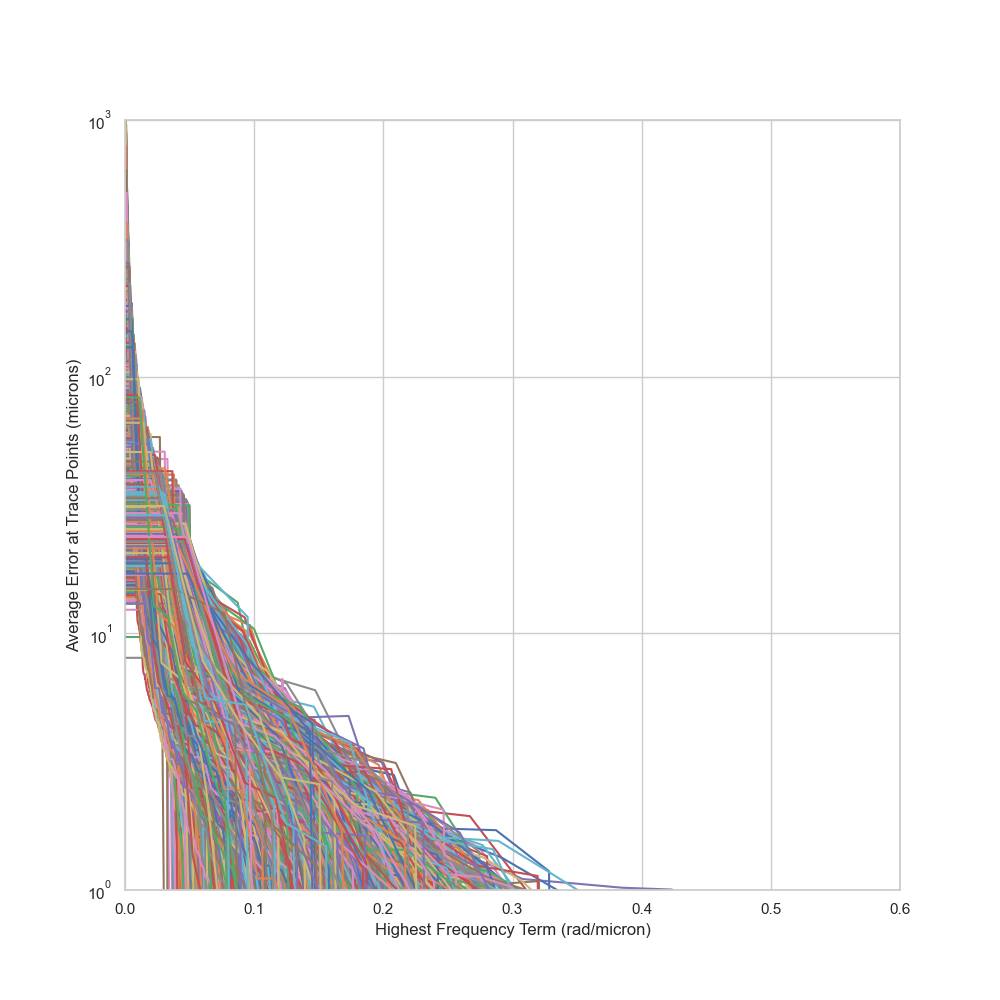

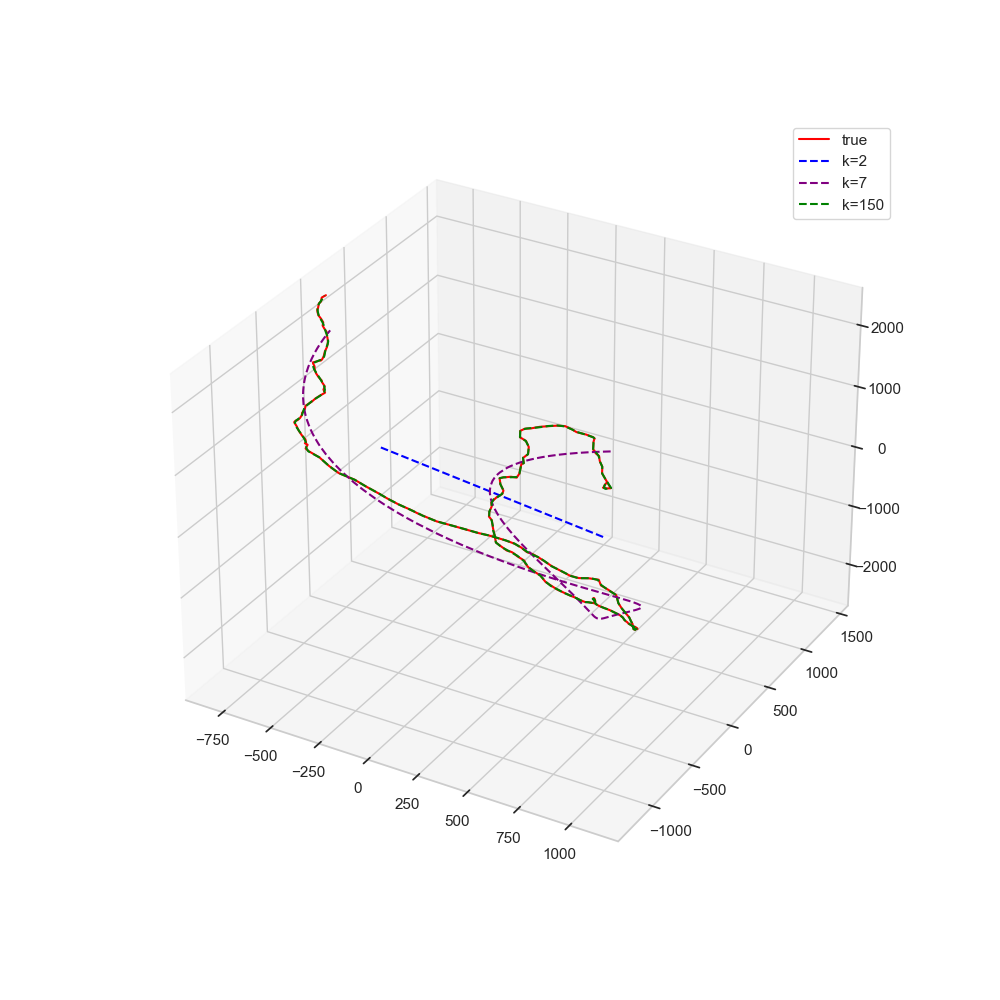

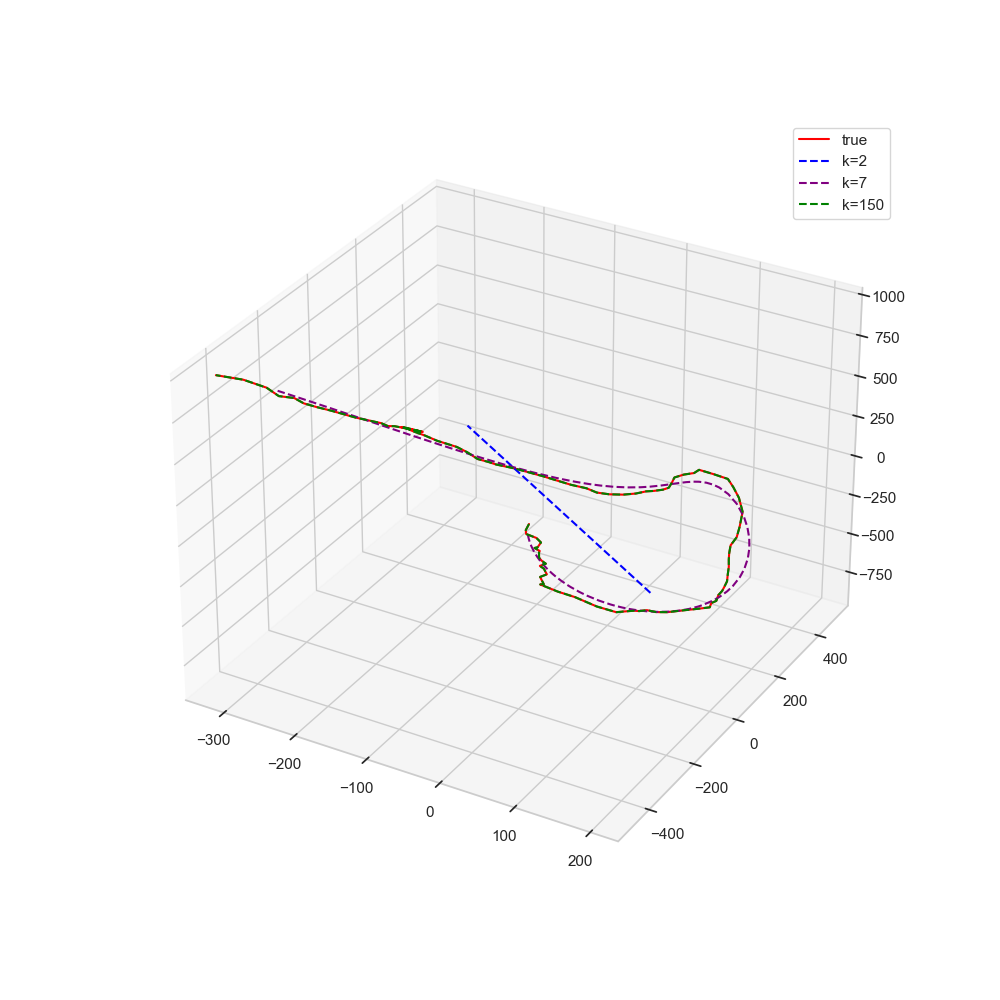

In [36]:
max_k = 150
error_thresh = 1

fig_coeffs = plt.figure(figsize=(10, 10))
ax_coeffs = plt.axes()

ks_below_thresh = []
counter = 0

for num_goal in tqdm(range(50), desc="processing neurons"):
    num = -1
    skel_id = -1
    while num < num_goal:
        skel_id += 1
        try:
            skel = vol.skeleton.get(skel_id)
            num += 1
        except SkeletonDecodeError:
            pass

    neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

    paths = neuron.get_paths()  # coordinates are in nm

    for path_n, path in enumerate(tqdm(paths, desc="Looping through paths", leave=False)):
        diffs = np.diff(path, axis=0)
        norms = np.linalg.norm(diffs, axis=1)
        norms = np.concatenate(([0], norms))
        ts = np.cumsum(norms)/1000
        if ts[-1] < 10*np.pi:
            continue
        counter += 1
        #ts = ts / ts[-1]

        Y = path/1000
        Y -= np.mean(Y, axis=0)

        k = np.amin([path.shape[0]*2, max_k])

        Psi = np.ones((len(ts), k))
        
        for l in range(1, k):
            col = np.sqrt(2) * np.cos(l * np.pi/ts[-1] * ts)
            Psi[:, l] = col

        C_hat = np.linalg.pinv(Psi) @ Y
        Y_hat = Psi @ C_hat

        # show neurons
        if num_goal == 0 and path_n < 3:
            fig_neuron = plt.figure(figsize=(10, 10))
            ax_neuron = plt.axes(projection='3d')
            ax_neuron.plot3D(Y[:,0], Y[:,1], Y[:,2], label="true", color='red')

            for l, c in zip(range(2,np.amin([10, k]), 5), ['blue', 'purple', 'pink']):
                C_hat_l = np.linalg.pinv(Psi[:,:l]) @ Y
                Y_hat_l =  Psi[:,:l] @ C_hat_l
                ax_neuron.plot3D(Y_hat_l[:,0], Y_hat_l[:,1], Y_hat_l[:,2], label=f"k={l}", linestyle='dashed', color=c)

            ax_neuron.plot3D(Y_hat[:,0], Y_hat[:,1], Y_hat[:,2], label=f"k={k}", linestyle='dashed', color='green')

            ax_neuron.legend()

        #look at goodness of fit (coefficients or rmsqe)
        Cs = np.abs(C_hat) ** 2

        averr = np.zeros((C_hat.shape[0]))
        for l in range(k):
            C_hat = np.linalg.pinv(Psi[:,:l]) @ Y
            Y_hat_l =  Psi[:,:l] @ C_hat[:l,:]
            averr[l] = np.mean(np.linalg.norm((Y-Y_hat_l), axis=1))

        if ts[-1] > 20*np.pi:
            color=next(ax_coeffs._get_lines.prop_cycler)['color']
            ax_coeffs.plot(np.arange(k)* np.pi/ts[-1], averr, label=f"{path_n}", color=color)

        where = np.argwhere(averr  < error_thresh)
        if np.sum(where) == 0:
            print(f"{path_n} path error does not fall below {error_thresh} min error: {np.amin(rmsqe, axis=0)}, max freq: {k*np.pi/ts[-1]}")
            print(np.amin(averr, axis=0))
        else:
            idx = (ts[-1]*2)/np.amin(where)
            ks_below_thresh.append(idx)
        #ax_coeffs.plot([idx, idx], [2000, error_thresh], label=f"{path_n}", color=color)

print(f"{len(ks_below_thresh)}/{counter} achieve error below {error_thresh}")

ax_coeffs.set_yscale("log")
ax_coeffs.set_ylim([10**0,10**3])
ax_coeffs.set_xlim([0,0.5])
ax_coeffs.set_ylabel("Average Error at Trace Points (microns)")
ax_coeffs.set_xlabel("Highest Frequency Term (rad/micron)")
plt.show()

fig_ks = plt.figure(figsize=(10, 5))
ax_ks = plt.axes()
data = {"Period to Achieve < 1 micron Average Error (microns)": ks_below_thresh}
df = pd.DataFrame(data)
sns.set_theme(style="whitegrid")
sns.stripplot(x="Period to Achieve < 1 micron Average Error (microns)", ax=ax_ks, data = df, alpha=0.1)
sns.boxplot(x="Period to Achieve < 1 micron Average Error (microns)", ax=ax_ks, data = df)
plt.show()